# Experimental Scaler testing model

---

# Setting up the Environment

---

## Environment Sanity Check
NOTE: This isn't necessary if just using sklearn and not cupy or cudf

Go to `Edit` > `Notebook Settings` > `Hardware Accelerator` and select `GPU` if not already selected

Check output of `!nvidia-smi` to make sure you have a Tesla T4, P4, or P100.

In [1]:
!nvidia-smi

Wed Oct 21 03:07:24 2020       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 455.23.05    Driver Version: 418.67       CUDA Version: 10.1     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla P4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   50C    P8     8W /  75W |      0MiB /  7611MiB |      0%      Default |
|                               |                      |                 ERR! |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
# Uncomment all this is deciding to implement cuml,cupy,cudf etc.

# Install RAPIDS
# Look at RAPIDS notebooks to see examples: https://github.com/rapidsai/notebooks

!git clone https://github.com/rapidsai/rapidsai-csp-utils.git
!bash rapidsai-csp-utils/colab/rapids-colab.sh stable

import sys, os

dist_package_index = sys.path.index('/usr/local/lib/python3.6/dist-packages')
sys.path = sys.path[:dist_package_index] + ['/usr/local/lib/python3.6/site-packages'] + sys.path[dist_package_index:]
sys.path
exec(open('rapidsai-csp-utils/colab/update_modules.py').read(), globals())

Cloning into 'rapidsai-csp-utils'...
remote: Enumerating objects: 14, done.
remote: Counting objects: 100% (14/14), done.
remote: Compressing objects: 100% (14/14), done.
remote: Total 185 (delta 5), reused 0 (delta 0), pack-reused 171
Receiving objects: 100% (185/185), 57.14 KiB | 392.00 KiB/s, done.
Resolving deltas: 100% (67/67), done.
PLEASE READ
********************************************************************************************************
Changes:
1. IMPORTANT CHANGES: RAPIDS on Colab will be pegged to 0.14 Stable until further notice.
2. Default stable version is now 0.14.  Nightly will redirect to 0.14.
3. You can now declare your RAPIDSAI version as a CLI option and skip the user prompts (ex: '0.14' or '0.15', between 0.13 to 0.14, without the quotes): 
        "!bash rapidsai-csp-utils/colab/rapids-colab.sh <version/label>"
        Examples: '!bash rapidsai-csp-utils/colab/rapids-colab.sh 0.14', or '!bash rapidsai-csp-utils/colab/rapids-colab.sh stable', or '!bash ra

In [24]:
import io, requests

import datetime
import pandas as pd
#import cudf
import cuml
import numpy as np
import cupy as cp
from time import time
from tqdm.notebook import tqdm

from sklearn.preprocessing import power_transform
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import StratifiedKFold
#from sklearn.linear_model import LogisticRegression
from cuml.linear_model.logistic_regression import LogisticRegression

from sklearn.metrics import log_loss

# Loading / Processing the Data

---

## Loading the data and some initial preprocessing

In [5]:
def dummy_vars(df):
    df.loc[:, 'cp_type'] = df.loc[:, 'cp_type'].map({'trt_cp': 0, 'ctl_vehicle': 1})
    # trt_cp is a control and has no MOA, ctl_vehicle indicates a real test
    df.loc[:, 'cp_dose'] = df.loc[:, 'cp_dose'].map({'D1': 0, 'D2': 1})
    # create columns ['cp_type_24', 'cp_type_48', 'cp_type_72'] which are one hot encoded based on cp_time
    df['cp_type_24'] = df['cp_time'].astype(str) == '24'
    df['cp_type_48'] = df['cp_time'].astype(str) == '48'
    df['cp_type_72'] = df['cp_time'].astype(str) == '72'
    df.drop(columns=['sig_id','cp_time'], inplace = True)
    return df

In [6]:
#########
# TO DO #
#################################################################
# after the yeo-johnson transformation on the numerical data    #
# one hot encode the categorical features                       #
# recombine the data so and run standarscaler                   #
#################################################################
# It looks like the yeo johnson transform is done column-wise   #
# Put the data in two long lists for the g- and c- features     #
# Perform yeo johnson on each                                   #
# put the data back into the df                                 #
#################################################################

# Train Features
train_features = pd.read_csv('drive/My Drive/Metis/train_features.csv')
train_features = dummy_vars(train_features)
print('train_features loaded')

# Train Targets
train_targets = pd.read_csv('drive/My Drive/Metis/train_targets_scored.csv')
train_targets.drop(columns=['sig_id'], inplace = True)
print('train_targets loaded')

# Test Features
test_features = pd.read_csv('drive/My Drive/Metis/test_features.csv')
test_features = dummy_vars(test_features)
#test_features = pd.DataFrame(power_transform(test_features, method='yeo-johnson'))
print('test_features loaded')

# Sample Submission DF (Targets)
ss_lr = pd.read_csv('drive/My Drive/Metis/sample_submission.csv')
ss_lr.drop(columns=['sig_id'], inplace = True)
print('ss_lr loaded')

print('done!')

train_features loaded
train_targets loaded
test_features loaded
ss_lr loaded
done!


## Defining the Logistic Regression Model

In [7]:
def log_loss_metric(y_true, y_pred):
    metrics = []
    for _target in train_targets.columns:
        metrics.append(log_loss(y_true.loc[:, _target], y_pred.loc[:, _target].astype(float), labels = [0,1]))
    return np.mean(metrics)

Logistic Regression

In [61]:
def k_fold_log_reg(model_train_num, column, x_test, target_vals, N_SPLITS):
  for rand_state in range(model_train_num):
  # train the model for each one of the random states 
    skf = StratifiedKFold(n_splits = N_SPLITS, random_state = rand_state, shuffle = True)

    for (train, val) in skf.split(target_vals, target_vals):
    # for each of the train/validate splits...

      x_train = X[train, column].reshape(-1, 1).astype(float)
      y_train = target_vals[train].astype(float)

      x_val = X[val, column].reshape(-1, 1).astype(float)
      y_val = target_vals[val].astype(float)

      model = LogisticRegression(C = 128, max_iter = 100000)
      model.fit(x_train, y_train)

      ss_pred_vals = cp.asnumpy(model.predict_proba(x_test[:, column].reshape(-1, 1).astype(float))[:, 1])
      ss_lr.loc[:, train_targets.columns[column]] += (
        ss_pred_vals / (N_SPLITS * model_train_num))

      res_pred_vals = cp.asnumpy(model.predict_proba(x_val)[:, 1].astype(float))
      res_lr.loc[val, train_targets.columns[column]] += (
        res_pred_vals / model_train_num)

In [65]:
def logreg(train_targets, X, x_test, ss_lr):
# train_targets is the training targets
# X is the train features
# x_test is the holdout set of features
# ss_lr ia blank since it's the empty sample submission predictions

  # cols = [c for c in ss_lr.columns.values]
  cols = ss_lr.columns.values

  lrg_target_sum = 0
  sml_target_sum = 0
  one_target_sum = 0

  N_SPLITS = 5 # number of k-fold splits
  model_train_num = 3 # number of random states the model is trained on for each target
  
  #keep this # small to allow easy iterating but switch back to 7 or 10 later

  for column in tqdm(range(train_targets.shape[1])):
  # create a model for each of the targets
      start_time = time()
      target_vals = train_targets.values[:, column]

      if target_vals.sum() >= 5:
        # split if there's enough positive target values
        lrg_target_sum += 1
        k_fold_log_reg(model_train_num, column, x_test, target_vals, N_SPLITS)

      score = log_loss(
       train_targets.loc[:, train_targets.columns[column]],
       res_lr.loc[:, train_targets.columns[column]]
       )
      feat_time = str(datetime.timedelta(seconds = time() - start_time))[2:7]
      #print(f'[{feat_time}] Target {column+1}/{train_targets.shape[1]} Log Loss:', score)
      target_counts.append(np.sum(target_vals))
      logloss_vals.append(score)

  print(f'Log Loss: {log_loss_metric(train_targets, res_lr)}')

  # these lines automatically set the target values equal to zero if it cp_type = 1 AKA control group  
  res_lr.loc[train_features['cp_type'] == 1, train_targets.columns] = 0
  ss_lr.loc[test_features['cp_type'] == 1, train_targets.columns] = 0
  print(f'After manually eliminating control groups: {log_loss_metric(train_targets, res_lr)}\n\n')
  #print(f'lrg_target_sum = {lrg_target_sum}\nsml_target_sum = {sml_target_sum}\none_target_sum = {one_target_sum}')


## Scaling the data

In [45]:
import matplotlib.pyplot as plt


Log Loss: 0.020382377366045732
After manually eliminating control groups: 0.0201054568946614




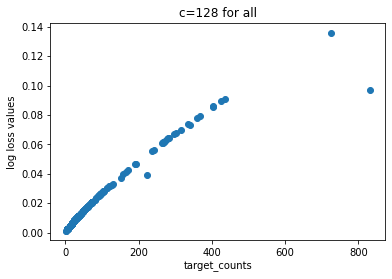

In [69]:
scaler = StandardScaler()

#X = scaler.fit_transform(train_features.values[:, top_feats])
X = scaler.fit_transform(train_features.values[:, :])

#x_test = scaler.transform(test_features.values[:, top_feats])
x_test = scaler.fit_transform(test_features.values[:,:])

#This is for the sample_submission.csv df
ss_lr.loc[:, train_targets.columns] = 0

#These are the target values which are being predicted and tested
res_lr = train_targets.copy()
res_lr.loc[:, train_targets.columns] = 0

for i in [i]:
  target_counts = []
  logloss_vals = []
  ss_lr.loc[:, train_targets.columns] = 0
  res_lr.loc[:, train_targets.columns] = 0
  logreg(train_targets, X, x_test, ss_lr)
  plt.scatter(target_counts,logloss_vals)
  plt.xlabel('target_counts')
  plt.ylabel('log loss values')
  plt.title('c=128 for all')
  plt.show()

In [70]:
ss_lr.to_csv('drive/My Drive/Metis/ss_lr.csv')
res_lr.to_csv('drive/My Drive/Metis/res_lr.csv')


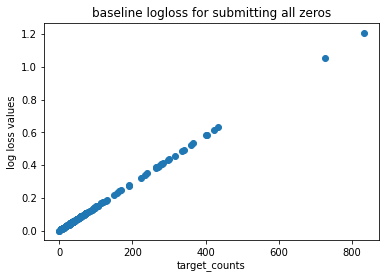

In [82]:
target_counts = []
logloss_vals = []
res_lr.loc[:, train_targets.columns] = 0
for i in range(res_lr.shape[1]):
  loss = log_loss(train_targets.iloc[:,i], res_lr.iloc[:,i])
  logloss_vals.append(loss)
  target_counts.append(np.sum(train_targets.iloc[:,i]))
plt.scatter(target_counts,logloss_vals)
plt.xlabel('target_counts')
plt.ylabel('log loss values')
plt.title('baseline logloss for submitting all zeros')
plt.show()

In [79]:
train_targets.iloc[:,i]

0        0
1        0
2        0
3        0
4        0
        ..
23809    0
23810    0
23811    0
23812    0
23813    0
Name: 5-alpha_reductase_inhibitor, Length: 23814, dtype: int64

In [80]:
res_lr.iloc[:,i]

0        0
1        0
2        0
3        0
4        0
        ..
23809    0
23810    0
23811    0
23812    0
23813    0
Name: 5-alpha_reductase_inhibitor, Length: 23814, dtype: int64